In [1]:
import os
import sys
import numpy as np
from PIL import Image
from skimage import io
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=3, batchnorm=True, last_activ=F.relu):
        super(ConvBlock, self).__init__()
        self.bn = batchnorm
        self.last_activ = last_activ
        self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
        self.b1 = nn.BatchNorm2d(out_filters)
        self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
        self.b2 = nn.BatchNorm2d(out_filters)
    def forward(self, x):
        x = self.c1(x)
        if self.bn: x = self.b1(x)
        x = F.relu(x)
        x = self.c2(x)
        if self.bn: x = self.b2(x)
        x = self.last_activ(x)
        return x

In [4]:
class ContractiveBlock(nn.Module):
    def __init__(self, in_filters, out_filters, conv_kern=3, pool_kern=2, dropout=0.5, batchnorm=True):
        super(ContractiveBlock, self).__init__()
        self.c1 = ConvBlock(in_filters=in_filters, out_filters=out_filters, kernel_size=conv_kern, batchnorm=batchnorm)
        self.p1 = nn.MaxPool2d(kernel_size=pool_kern)
        self.d1 = nn.Dropout2d(dropout)
    def forward(self, x):
        c = self.c1(x)
        return c, self.d1(self.p1(c))

In [5]:
class ExpansiveBlock(nn.Module):
    def __init__(self, in_filters1, in_filters2, out_filters, tr_kern=3, conv_kern=3, stride=2, dropout=0.5):
        super(ExpansiveBlock, self).__init__()
        self.t1 = nn.ConvTranspose2d(in_filters1, out_filters, tr_kern, stride=2, padding=1, output_padding=1)
        self.d1 = nn.Dropout(dropout)
        self.c1 = ConvBlock(out_filters+in_filters2, out_filters, conv_kern)
        
    def forward(self, x, contractive_x):
        x_ups = self.t1(x)
        x_concat = torch.cat([x_ups, contractive_x], 1)
        x_fin = self.c1(self.d1(x_concat))
        return x_fin

In [6]:
class Unet(nn.Module):
    def __init__(self, n_labels, n_filters=16, p_dropout=0.5, batchnorm=True):
        super(Unet, self).__init__()
        filter_dict = {}
        filt_pair = [3, n_filters]
        
        for i in range(4):
            self.add_module('contractive_'+str(i), ContractiveBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm))
            filter_dict['contractive_'+str(i)] = (filt_pair[0], filt_pair[1])
            filt_pair[0] = filt_pair[1]
            filt_pair[1] = filt_pair[1] * 2
        
        self.bottleneck = ConvBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm)
        filter_dict['bottleneck'] = (filt_pair[0], filt_pair[1])
        
        for i in reversed(range(4)):
            self.add_module('expansive_'+str(i), ExpansiveBlock(filt_pair[1], filter_dict['contractive_'+str(i)][1], filt_pair[0]))
            filter_dict['expansive_'+str(i)] = (filt_pair[1], filt_pair[0])
            filt_pair[1] = filt_pair[0]
            filt_pair[0] = filt_pair[0] // 2
        
        self.output = nn.Conv2d(filt_pair[1], n_labels, kernel_size=1)
        filter_dict['output'] = (filt_pair[1], n_labels)
        self.filter_dict = filter_dict
    
    def forward(self, x):
        c00, c0 = self.contractive_0(x)
        c11, c1 = self.contractive_1(c0)
        c22, c2 = self.contractive_2(c1)
        c33, c3 = self.contractive_3(c2)
        bottle = self.bottleneck(c3)
        u3 = F.relu(self.expansive_3(bottle, c33))
        u2 = F.relu(self.expansive_2(u3, c22))
        u1 = F.relu(self.expansive_1(u2, c11))
        u0 = F.relu(self.expansive_0(u1, c00))
        return F.softmax(self.output(u0), dim=1)

In [7]:
net = Unet(2).cuda()

In [8]:
net.load_state_dict(torch.load('test.pth'))
net.eval();

In [9]:
def create_patches(image_path, t_dir):
    im = Image.open(image_path)
    print(im.size)
    new_size = int(256*np.ceil(im.size[0]/256)),int(256*np.ceil(im.size[1]/256))
    print(new_size)
    im = im.resize(new_size)

    im = np.array(im)
    for i,x in enumerate(range(0,new_size[0],256)):
        for j,y in enumerate(range(0,new_size[1],256)):
            new_im = im[x:x+256,y:y+256]
            io.imsave(arr=new_im,fname=t_dir + str(i).zfill(3)+'_'+str(j).zfill(3)+".jpg")

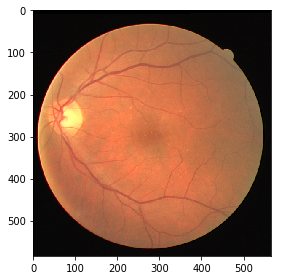

In [10]:
image_path = 'DRIVE/training/images/21_training.tif'
io.imshow(image_path)

(565, 584)
(768, 768)


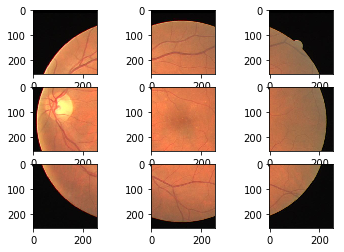

In [11]:
create_patches(image_path,'data/test_patches/')

l = sorted(os.listdir('data/test_patches/'))
dirp = 'data/test_patches/'
plt.figure(1)
for i in range(3):
    for j in range(3):
        im = Image.open(dirp + str(i).zfill(3)+"_"+str(j).zfill(3)+".jpg")
        plt.subplot('33'+str(i*3+j+1))
        plt.imshow(im)

In [12]:
data_tranform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

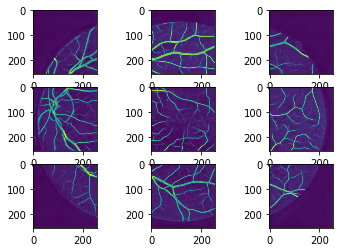

In [13]:
l = sorted(os.listdir('data/test_patches/'))
images=[]
for i in l:
    im = data_tranform(Image.open('data/test_patches/' + i))
    images.append(im.unsqueeze(0))
images = torch.cat(images).cuda()
pred = net(images).cpu().detach().numpy()

l = sorted(os.listdir('data/test_patches/'))
dirp = 'data/test_patches/'
plt.figure(1)

full_image = []
for i in range(3):
    col_im = []
    for j in range(3):
        plt.subplot('33'+str(i*3+j+1))
        plt.imshow(pred[i*3+j][0])
        col_im.append(pred[i*3+j][0])
    full_image.append(col_im)

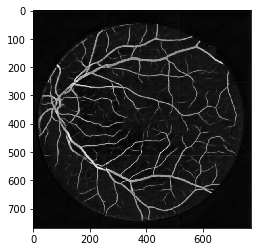

In [15]:
stitch = []
for i in full_image:
    col_im = []
    for j in i:
        col_im.append(j)
    col_im = np.hstack(col_im)
    stitch.append(col_im)
stitch = np.vstack(stitch)
plt.imshow(stitch,cmap='gray')